In [49]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points
from multiprocessing import Pool, cpu_count
from sklearn.neighbors import BallTree
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')


flowlines_gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
spills_gdf   = gpd.read_file("clean_spills.geojson")

projected_crs = spills_gdf.estimate_utm_crs()
flowlines_gdf  = flowlines_gdf.to_crs(projected_crs)
spills_gdf    = spills_gdf.to_crs(projected_crs)

In [50]:
matched_spills      = []
matched_spill_count = 0
missing_geom_spill  = 0
no_op_spill         = 0
no_match_spill      = 0

for idx, spill in spills_gdf.iterrows():
    pt = spill.geometry
    if pt is None or pt.is_empty:
        print(f"[Spill {idx}] Missing geometry – skipping.")
        missing_geom_spill += 1
        continue

    op = spill.get("operator_name", "")
    if pd.isnull(op) or not op.strip():
        print(f"[Spill {idx}] No operator_name – skipping.")
        no_op_spill += 1
        continue

    op_name = op.strip().lower()
    candidates = flowlines_gdf[
        flowlines_gdf["operator_name"]
            .astype(str)  # ensure string for comparison
            .str.strip()
            .str.lower()
            .eq(op_name)
    ].copy()
    candidates = candidates[candidates.geometry.notnull()]

    if candidates.empty:
        print(f"[Spill {idx}] No flowlines for operator “{op}”.")
        no_match_spill += 1
        continue

    dists = candidates.geometry.distance(pt).dropna()
    if dists.empty:
        print(f"[Spill {idx}] All distances NaN – skipping.")
        no_match_spill += 1
        continue

    nearest_idx  = dists.idxmin()
    min_dist     = dists.min()
    nearest_line = flowlines_gdf.loc[nearest_idx]

    # exact nearest point on the line
    _, nearest_pt = nearest_points(pt, nearest_line.geometry)

    matched_spill_count += 1
    print(f"[Match {matched_spill_count}] spill {idx} → flowline {nearest_idx} at {min_dist:.2f} m")

    # build a new row: copy all original spill attributes but add match info
    new_spill = spill.copy()
    new_spill["match_point"]          = nearest_pt
    new_spill["match_distance_m"]     = min_dist
    new_spill["matched_flowline_idx"] = nearest_idx

    matched_spills.append(new_spill)

[Spill 0] No flowlines for operator “K P KAUFFMAN COMPANY INC”.
[Match 1] spill 1 → flowline 11963 at 26869.64 m
[Spill 2] No flowlines for operator “GRYNBERG* JACK DBA GRYNBERG PETROLEUM CO”.
[Match 2] spill 3 → flowline 67266 at 2477.45 m
[Match 3] spill 4 → flowline 100395 at 2088.51 m
[Match 4] spill 5 → flowline 23829 at 10.85 m
[Match 5] spill 6 → flowline 11667 at 17.69 m
[Match 6] spill 7 → flowline 19840 at 1166.32 m
[Match 7] spill 8 → flowline 109253 at 2897.16 m
[Match 8] spill 9 → flowline 111404 at 2582.50 m
[Match 9] spill 10 → flowline 1309 at 27.22 m
[Match 10] spill 11 → flowline 99247 at 389.26 m
[Match 11] spill 12 → flowline 29302 at 3.39 m
[Match 12] spill 13 → flowline 96890 at 18.65 m
[Match 13] spill 14 → flowline 43167 at 102.90 m
[Match 14] spill 15 → flowline 86987 at 2.74 m
[Match 15] spill 16 → flowline 69454 at 81.01 m
[Match 16] spill 17 → flowline 91275 at 3803.22 m
[Match 17] spill 18 → flowline 99048 at 12.44 m
[Match 18] spill 19 → flowline 55500 at 

In [19]:
print("\n=== Spills Matching Complete ===")
print(f"Total spills:              {len(spills_gdf)}")
print(f"Matched spills:            {matched_spill_count}")
print(f"Missing geometry spills:   {missing_geom_spill}")
print(f"No Operator Name spills:   {no_op_spill}")
print(f"No line match spills:      {no_match_spill}")

matched_spills_gdf = gpd.GeoDataFrame(matched_spills)


=== Spills Matching Complete ===
Total spills:              1114
Matched spills:            943
Missing geometry spills:   0
No Operator Name spills:   0
No line match spills:      171


In [20]:
matched_spills_gdf = matched_spills_gdf.rename(columns={"geometry": "orig_geometry"})
matched_spills_gdf["geometry"] = matched_spills_gdf["match_point"]
matched_spills_gdf = matched_spills_gdf.set_geometry("geometry")

matched_spills_gdf = matched_spills_gdf.set_crs(projected_crs, allow_override=True)
matched_spills_gdf = matched_spills_gdf.to_crs(epsg=4326)
matched_spills_gdf = matched_spills_gdf.drop(columns=["orig_geometry", "match_point"])
matched_spills_gdf.to_file("updated_spills.geojson", driver="GeoJSON")
print("Wrote updated_spills.geojson in EPSG:4326.")

Wrote updated_spills.geojson in EPSG:4326.


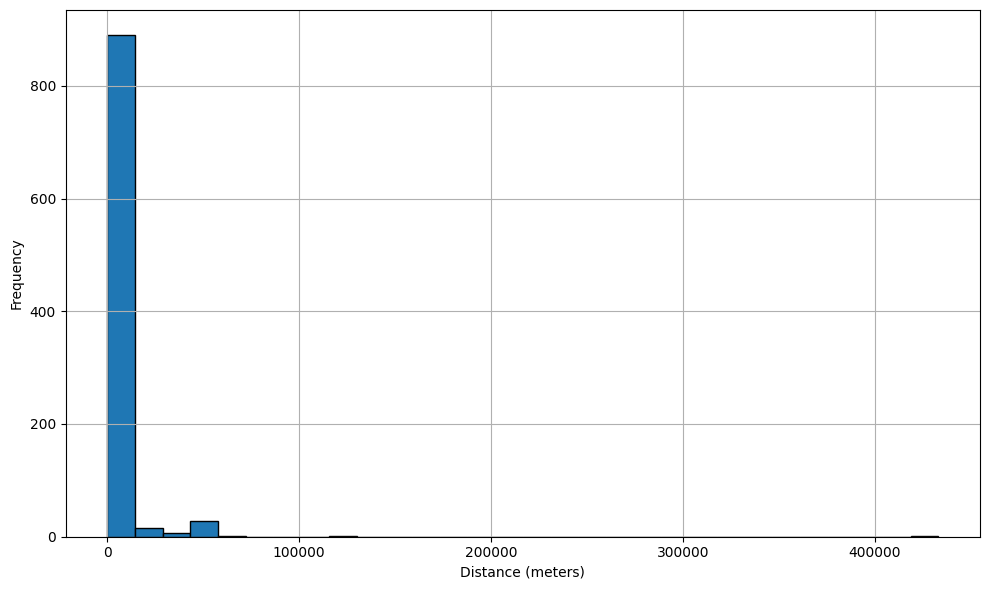

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(matched_spills_gdf["match_distance_m"].dropna(), bins=30, edgecolor="black")
# plt.title("Distance Between Original and Matched Spill Points")
plt.xlabel("Distance (meters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

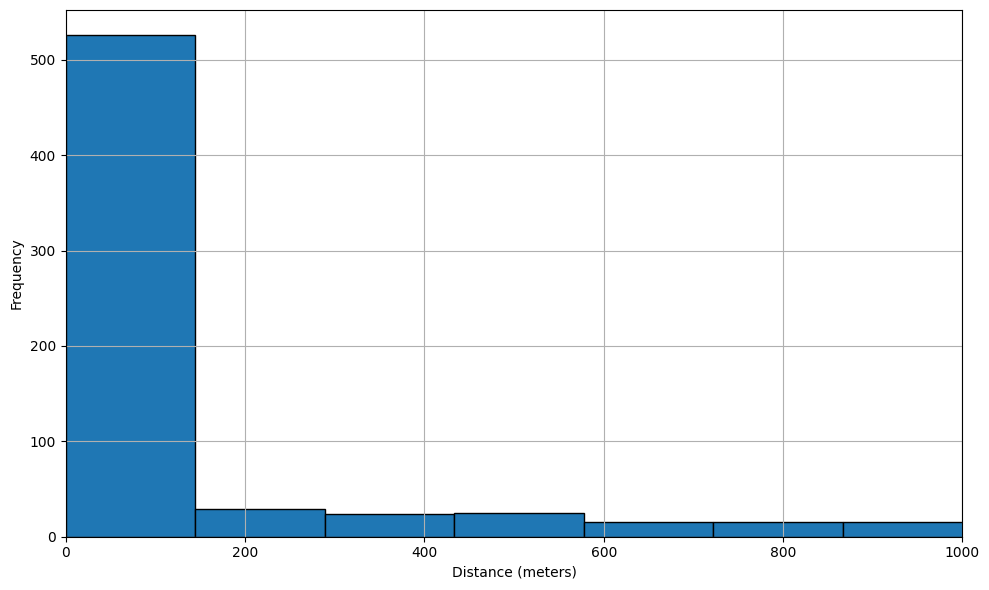

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(matched_spills_gdf["match_distance_m"].dropna(), bins=3000, edgecolor="black")
# plt.title("Distance Between Original and Matched Spill Points (Zoomed In)")
plt.xlabel("Distance (meters)")
plt.ylabel("Frequency")
plt.xlim(0, 1000)
plt.grid(True)
plt.tight_layout()
plt.show()

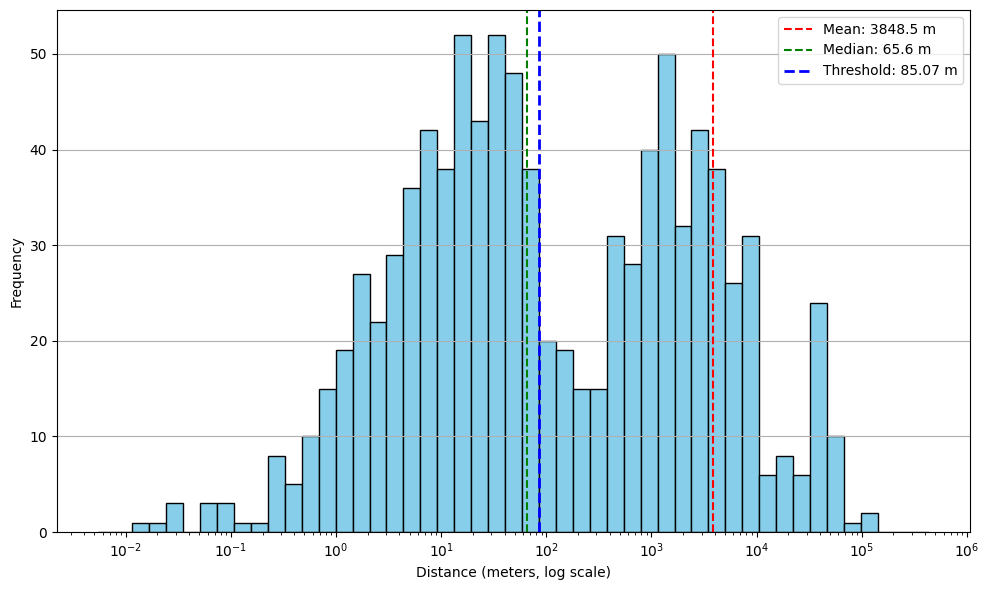

Threshold distance (last freq > 30 before 2nd mode): 85.07 m


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# --- Drop NA and filter positive distances ---
distances = matched_spills_gdf["match_distance_m"].dropna()
distances = distances[distances > 0]

# --- Compute mean and median ---
mean_dist = distances.mean()
median_dist = distances.median()

# --- Log-spaced bins ---
min_val = distances.min()
max_val = distances.max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# --- Histogram ---
plt.figure(figsize=(10, 6))
counts, bin_edges, patches = plt.hist(distances, bins=bins, edgecolor="black", color="skyblue")

# --- Smooth counts for mode detection ---
counts_smooth = gaussian_filter1d(counts.astype(float), sigma=1.5)

# --- Find peaks (modes) ---
peak_idx, _ = find_peaks(counts_smooth, prominence=5)
peak_idx = np.sort(peak_idx)
if len(peak_idx) >= 2:
    # Valley between first and second mode
    first_mode, second_mode = peak_idx[0], peak_idx[1]
    valley_slice = slice(first_mode, second_mode)
    valley_rel = np.argmin(counts_smooth[valley_slice])
    split_index = first_mode + valley_rel

    # Last bin > 30 before second mode
    last_idx = next((i for i in range(split_index - 1, -1, -1) if counts[i] > 30), None)
    if last_idx is not None:
        threshold_value = float(bin_edges[last_idx + 1])
    else:
        threshold_value = None
else:
    threshold_value = None

# --- Add vertical lines ---
plt.axvline(mean_dist, color='red', linestyle='--', label=f'Mean: {mean_dist:.1f} m')
plt.axvline(median_dist, color='green', linestyle='--', label=f'Median: {median_dist:.1f} m')
if threshold_value is not None:
    plt.axvline(threshold_value, color='blue', linestyle='--', linewidth=2, 
                label=f'Threshold: {threshold_value:.2f} m')

# --- Log scale + styling ---
plt.xscale("log")
plt.xlabel("Distance (meters, log scale)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print threshold ---
if threshold_value is not None:
    print(f"Threshold distance (last freq > 30 before 2nd mode): {threshold_value:.2f} m")
else:
    print("No threshold found before the second mode.")

In [38]:
# Find last bin > 30 *before* the split (second mode)
last_idx = next((i for i in range(split_index - 1, -1, -1) if counts[i] > 30), None)

if last_idx is None:
    print("No bins with count > 30 before the second mode.")
else:
    # Single threshold value = upper edge of that bin (conservative on a log scale)
    threshold_m = float(bin_edges[last_idx + 1])
    print(f"Threshold distance (last freq > 30 before 2nd mode): {threshold_m:.2f} m")

Threshold distance (last freq > 30 before 2nd mode): 85.07 m


/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_2563/2882973213.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


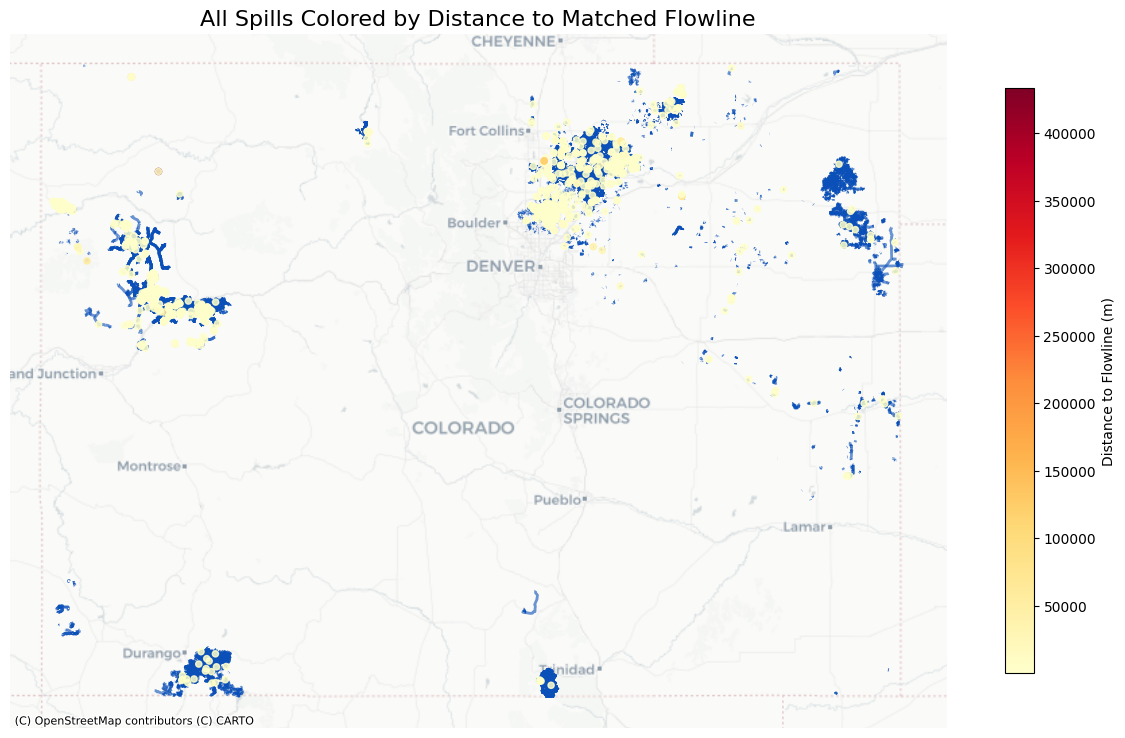

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import contextily as ctx

# === Load & Prepare Data ===
flowlines_gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
spills_gdf = gpd.read_file("updated_spills.geojson")

# Keep only point geometries for spills
spills_gdf = spills_gdf[spills_gdf.geometry.type.isin(['Point', 'MultiPoint'])].copy()

# No filtering to 110m — plot full dataset
assert 'match_distance_m' in spills_gdf.columns, "Column 'match_distance_m' not found in spills data."

# === Define Map Plotting Function ===
def plot_flowlines_and_spills(flowlines_gdf, spills_gdf, distance_col='match_distance_m', zoom_bounds=None):
    """
    Plot flowlines and all spill points with match distances using a YlOrRd gradient.
    """

    # Convert to Web Mercator
    flowlines = flowlines_gdf.to_crs(epsg=3857)
    spills = spills_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot flowlines
    flowlines.plot(
        ax=ax,
        color="#0B50B8",
        linewidth=2,
        alpha=0.6,
        zorder=2,
        label="Flowlines"
    )

    # Plot spills with full distance range using YlOrRd
    distances = spills[distance_col]
    norm = mcolors.Normalize(vmin=distances.min(), vmax=distances.max())
    cmap = cm.get_cmap("YlOrRd")

    spills.plot(
        ax=ax,
        column=distance_col,
        cmap=cmap,
        norm=norm,
        markersize=20,
        alpha=0.85,
        legend=True,
        zorder=3,
        legend_kwds={
            'label': "Distance to Flowline (m)",
            'shrink': 0.5
        }
    )

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=1)

    # Optional zoom
    if zoom_bounds:
        x_min, x_max, y_min, y_max = zoom_bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    ax.set_title("All Spills Colored by Distance to Matched Flowline", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# === Call the Function ===
plot_flowlines_and_spills(
    flowlines_gdf=flowlines_gdf,
    spills_gdf=spills_gdf,
    distance_col='match_distance_m',
    zoom_bounds=None
)

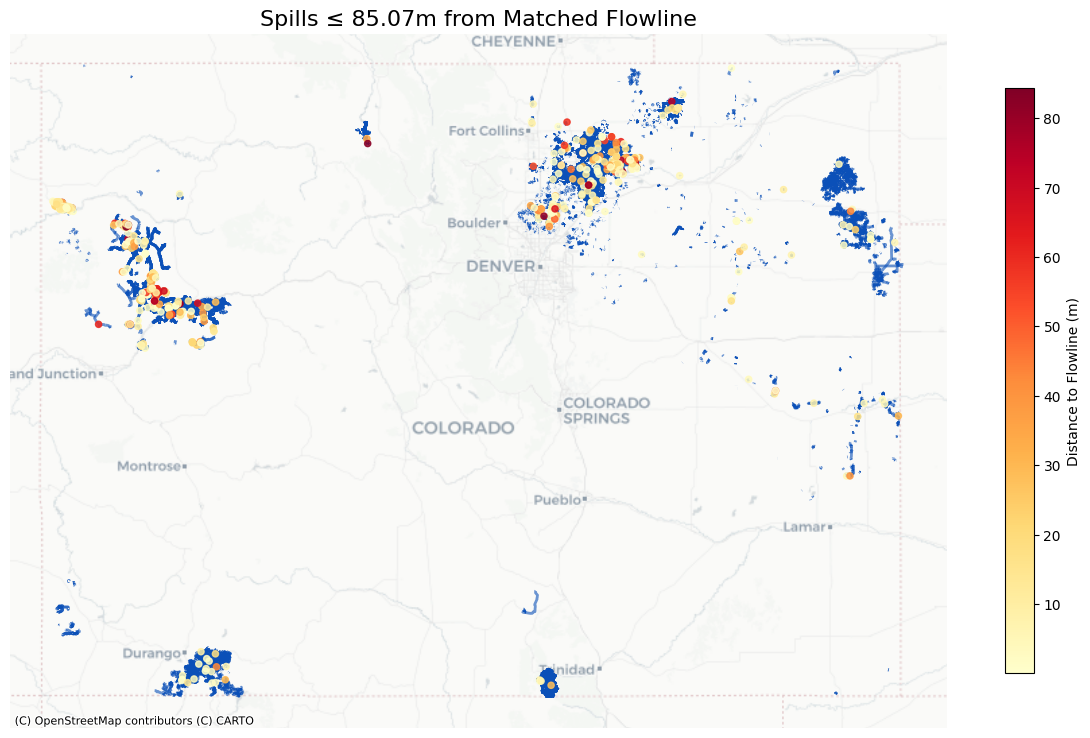

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx

# === Load & Prepare Data ===
flowlines_gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
spills_gdf = gpd.read_file("updated_spills.geojson")

# Keep only point geometries for spills
spills_gdf = spills_gdf[spills_gdf.geometry.type.isin(['Point', 'MultiPoint'])].copy()

# Ensure distance column exists
assert 'match_distance_m' in spills_gdf.columns, "Column 'match_distance_m' not found in spills data."

# ✅ Filter to only spills ≤ 85.07 meters
spills_gdf = spills_gdf[spills_gdf['match_distance_m'] <= 85.07].copy()

# === Define Map Plotting Function ===
def plot_flowlines_and_spills(flowlines_gdf, spills_gdf, distance_col='match_distance_m', zoom_bounds=None):
    """
    Plot flowlines and spill points with spill distances as a color gradient.
    """

    # Convert to Web Mercator
    flowlines = flowlines_gdf.to_crs(epsg=3857)
    spills = spills_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot flowlines (underneath spills)
    flowlines.plot(ax=ax, color="#0B50B8", linewidth=2, alpha=0.6, label="Flowlines", zorder=2)

    # Add basemap BEFORE plotting spills so spills appear on top
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=1)

    # Plot spills colored by distance
    distances = spills[distance_col]
    norm = mcolors.Normalize(vmin=distances.min(), vmax=distances.max())
    cmap = plt.cm.YlOrRd

    spills.plot(
        ax=ax,
        column=distance_col,
        cmap=cmap,
        norm=norm,
        markersize=20,
        alpha=0.85,
        legend=True,
        zorder=3,
        legend_kwds={
            'label': "Distance to Flowline (m)",
            'shrink': 0.5
        }
    )

    # Zoom if requested
    if zoom_bounds:
        x_min, x_max, y_min, y_max = zoom_bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    ax.set_title("Spills ≤ 85.07m from Matched Flowline", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# === Call the Function ===
plot_flowlines_and_spills(
    flowlines_gdf=flowlines_gdf,
    spills_gdf=spills_gdf,
    distance_col='match_distance_m',
    zoom_bounds=None
)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_2563/3847797683.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = cm.get_cmap("YlOrRd")


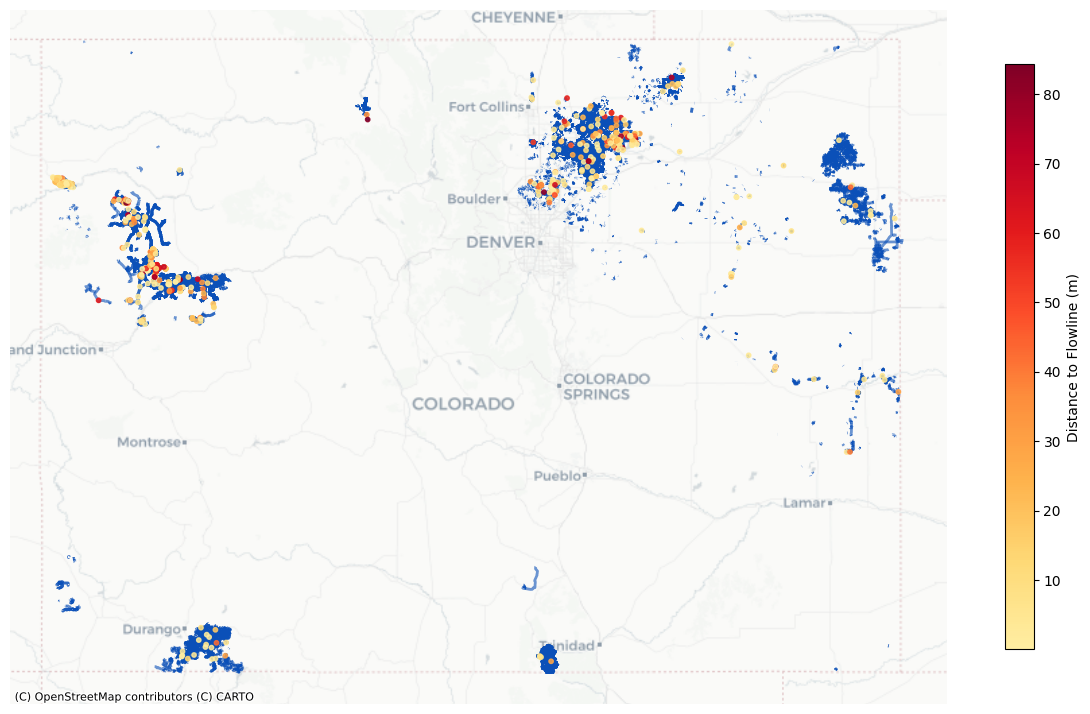

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import contextily as ctx
import numpy as np
from matplotlib.colors import ListedColormap

# === Load & Prepare Data ===
flowlines_gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
spills_gdf = gpd.read_file("updated_spills.geojson")

# Keep only point geometries
spills_gdf = spills_gdf[spills_gdf.geometry.type.isin(['Point', 'MultiPoint'])].copy()

# Filter to spills ≤ 85.07m
spills_gdf = spills_gdf[spills_gdf['match_distance_m'] <= 85.07].copy()

# === Plotting Function ===
def plot_flowlines_and_spills(flowlines_gdf, spills_gdf, distance_col='match_distance_m', zoom_bounds=None):
    flowlines = flowlines_gdf.to_crs(epsg=3857)
    spills = spills_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot flowlines (underneath)
    flowlines.plot(
        ax=ax,
        color="#0B50B8",  # vivid blue
        linewidth=2,
        alpha=0.6,
        zorder=2
    )

    # Basemap (bottom layer)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=1)

    # Create truncated colormap (darker starting yellow)
    original_cmap = cm.get_cmap("YlOrRd")
    truncated_cmap = ListedColormap(original_cmap(np.linspace(0.12, 1.0, 256)))

    # Plot spills with truncated YlOrRd colormap
    distances = spills[distance_col]
    norm = mcolors.Normalize(vmin=distances.min(), vmax=distances.max())

    spills.plot(
        ax=ax,
        column=distance_col,
        cmap=truncated_cmap,
        norm=norm,
        markersize=10,
        alpha=0.85,
        legend=True,
        zorder=3,
        legend_kwds={
            'label': "Distance to Flowline (m)",
            'shrink': 0.5
        }
    )

    if zoom_bounds:
        x_min, x_max, y_min, y_max = zoom_bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # ax.set_title("Spills Relocated to Nearest Flowline, Colored by Match Distance (≤85.07m)", fontsize=16, color="#444444")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# === Call the function ===
plot_flowlines_and_spills(
    flowlines_gdf=flowlines_gdf,
    spills_gdf=spills_gdf,
    distance_col='match_distance_m'
)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_2563/3323660667.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = get_cmap("YlOrRd")


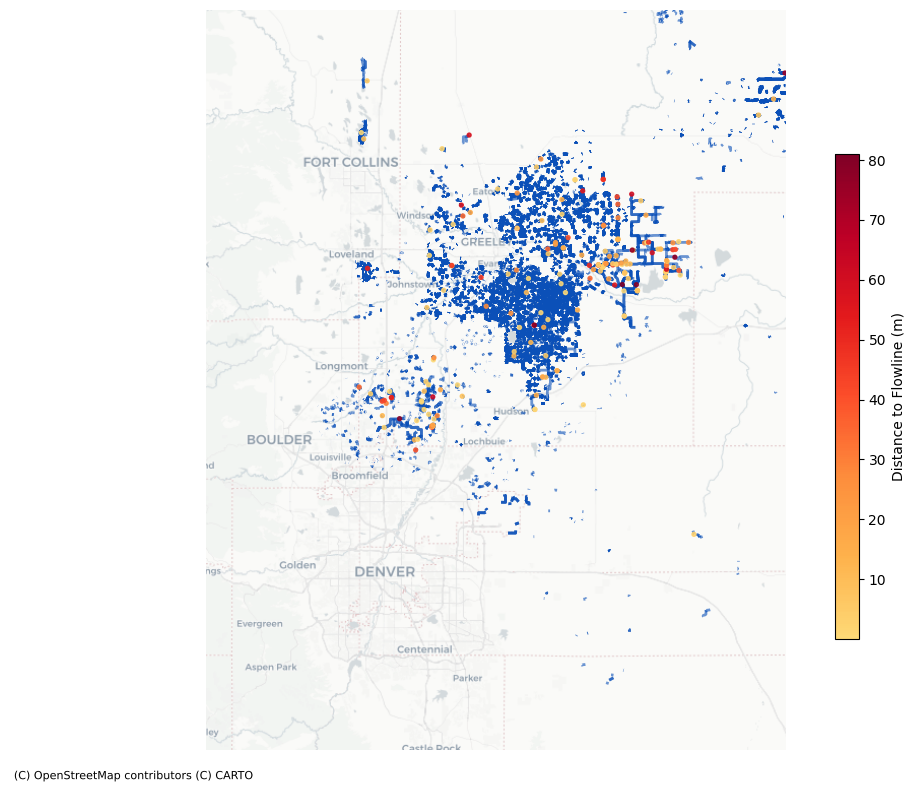

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from shapely.geometry import box

# === Load Data ===
flowlines_gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
spills_gdf = gpd.read_file("updated_spills.geojson")

# Keep only point geometries and filter to ≤ 110 meters
spills_gdf = spills_gdf[spills_gdf.geometry.type.isin(['Point', 'MultiPoint'])].copy()
spills_gdf = spills_gdf[spills_gdf['match_distance_m'] <= 85.07].copy()

# Define updated bounding box in WGS84 (wider extent)
bbox_wgs84 = box(-106.0, 39.3, -103.9, 40.9)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=3857)
x_min, y_min, x_max, y_max = bbox_gdf.total_bounds

# === Truncated YlOrRd colormap (start at darker yellow) ===
original_cmap = get_cmap("YlOrRd")
truncated_cmap = ListedColormap(original_cmap(np.linspace(0.25, 1.0, 256)))

# === Project and Clip Data ===
flowlines = flowlines_gdf.to_crs(epsg=3857).clip(bbox_gdf.geometry.iloc[0])
spills = spills_gdf.to_crs(epsg=3857).clip(bbox_gdf.geometry.iloc[0])

# === Plotting ===
fig, ax = plt.subplots(figsize=(10, 10))

# Flowlines
flowlines.plot(
    ax=ax,
    color="#0B50B8",  # deep blue
    linewidth=2,
    alpha=0.6,
    zorder=2
)

# Spills colored by distance with truncated colormap
distances = spills['match_distance_m']
norm = mcolors.Normalize(vmin=distances.min(), vmax=distances.max())

spills.plot(
    ax=ax,
    column='match_distance_m',
    cmap=truncated_cmap,
    norm=norm,
    markersize=8,
    alpha=0.85,
    legend=True,
    zorder=3,
    legend_kwds={
        'label': "Distance to Flowline (m)",
        'shrink': 0.5
    }
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=1)

# Set map extent
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Final formatting
ax.set_title("Spills Relocated to Nearest Flowline (≤110m) — Boulder–Greeley Area", fontsize=14, color="#444444")
ax.set_axis_off()
plt.tight_layout()

# Save and show
plt.savefig("spills_boulder_greeley_cropped.png", bbox_inches='tight', dpi=300)
plt.show()


In [13]:
import geopandas as gpd

# Load the dataset
matched_spills_gdf = gpd.read_file("updated_spills.geojson")

# Filter to only include matched distances < 110 meters
matched_spills_gdf = matched_spills_gdf[matched_spills_gdf['match_distance_m'] < 110].copy()

# Ensure the CRS is EPSG:4326 before saving
matched_spills_gdf = matched_spills_gdf.to_crs(epsg=4326)

# Save the filtered dataset
matched_spills_gdf.to_file("updated_spills_under_110m.geojson", driver="GeoJSON")
print("Wrote updated_spills_under_110m.geojson in EPSG:4326.")

Wrote updated_spills_under_110m.geojson in EPSG:4326.


In [14]:
import geopandas as gpd

# Load all three datasets
spills_raw = gpd.read_file("spills.geojson")
matched_spills = gpd.read_file("updated_spills.geojson")
matched_under_110 = gpd.read_file("updated_spills_under_110m.geojson")

# Count features in each
n_raw = len(spills_raw)
n_matched = len(matched_spills)
n_under_110 = len(matched_under_110)

# Print the summary
print(f"Original spill points (spills.geojson):               {n_raw}")
print(f"Matched spills (updated_spills.geojson):             {n_matched}")
print(f"Matched spills under 110m (updated_spills_under_110m.geojson): {n_under_110}")
print(f"Retention rate under 110m:                           {n_under_110 / n_raw:.2%}")

Original spill points (spills.geojson):               1199
Matched spills (updated_spills.geojson):             834
Matched spills under 110m (updated_spills_under_110m.geojson): 613
Retention rate under 110m:                           51.13%


In [ ]:
# ------------------------------------------------------------------------------
# 11. Load full_length_flowlines (in WGS84) and updated spills
# ------------------------------------------------------------------------------
crudeoil_wgs = gpd.read_file("full_length_flowlines.geojson").to_crs(epsg=4326)
spills_wgs   = gpd.read_file("updated_spills_under_110m.geojson")  # already EPSG:4326

# ------------------------------------------------------------------------------
# 12. Build joined_rows by combining spill geometry + flowline attributes
# ------------------------------------------------------------------------------
joined_rows = []
for _, spill in spills_wgs.iterrows():
    line_idx = spill["matched_crudeoil_idx"]
    line     = crudeoil_wgs.loc[line_idx]

    # Start with all crudeoil attributes (excluding its geometry)
    new_row = line.drop(labels=["geometry"]).copy()

    # Add all spill attributes (excluding geometry, matched_crudeoil_idx, match_distance_m)
    for col in spill.index:
        if col in ["geometry", "matched_crudeoil_idx", "match_distance_m"]:
            continue
        new_row[f"spill_{col}"] = spill[col]

    # Explicitly add match distance
    new_row["spill_match_distance_m"] = spill["match_distance_m"]

    # Use spill geometry instead of line geometry
    new_row["geometry"] = spill.geometry

    joined_rows.append(new_row)

# ------------------------------------------------------------------------------
# 13. Create GeoDataFrame of spills with appended flowline attributes
# ------------------------------------------------------------------------------
joined_gdf = gpd.GeoDataFrame(
    pd.DataFrame(joined_rows),
    geometry="geometry",
    crs=spills_wgs.crs
)
# ------------------------------------------------------------------------------
# 14. Add risk column and set all values to 1
# ------------------------------------------------------------------------------
joined_gdf["risk"] = 1

# ------------------------------------------------------------------------------
# 15. Extract numeric X, Y, and coords from spill geometry
# ------------------------------------------------------------------------------
joined_gdf["X"]      = joined_gdf.geometry.x
joined_gdf["Y"]      = joined_gdf.geometry.y
joined_gdf["coords"] = list(zip(joined_gdf["X"], joined_gdf["Y"]))

# ------------------------------------------------------------------------------
# 16. Save the final spills GeoDataFrame (with flowline attributes, X, Y, coords, and risk)
# ------------------------------------------------------------------------------
joined_gdf.to_file(
    "spills_w_flowline_attributes.geojson",
    driver="GeoJSON"
)
print(f"Created {len(joined_gdf)} spill-points with appended flowline attributes, X/Y/coords, and risk=1.")

Created 613 spill-points with appended flowline attributes, X/Y/coords, and risk=1.
